# Analysis of Calcium Imaging Data from Macaque SMA During Reaching

**NOTE: This notebook was AI-generated using dandi-notebook-gen and has not been fully verified. Please carefully review and validate all code and results.**

This notebook demonstrates how to access and analyze calcium imaging data from DANDI:001174, which contains calcium imaging recordings from the supplementary motor area (SMA) and primary motor cortex (M1) of macaque monkeys during a reaching task.

## Dataset Overview
- **Name**: Calcium imaging in SMA and M1 of macaques
- **Description**: This dataset contains one-photon calcium imaging recordings from deep layers of the supplementary motor (SMA) and primary motor areas (M1) in rhesus macaques. The recordings were performed while the animals were at rest or engaged in an arm reaching task.
- **Species**: Macaca mulatta
- **Technique**: One-photon calcium imaging using miniature microscopes
- **Brain Regions**: SMA and M1
- **Experimental Context**: Recordings during rest and arm reaching tasks

## Required Packages

This notebook requires the following Python packages:
- pynwb (for reading NWB files)
- lindi (for accessing remote NWB files)
- numpy (for numerical operations)
- matplotlib (for plotting)

These should be installed in your Python environment before running this notebook.

In [1]:
import pynwb
import lindi
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style for better plotting
sns.set_theme()

## Loading the Dataset

First, let's connect to the DANDI archive and list all available assets in this dataset.

In [2]:
from dandi.dandiapi import DandiAPIClient

# Connect to DANDI archive
client = DandiAPIClient()
dandiset = client.get_dandiset("001174")
assets = list(dandiset.get_assets())

print(f"Found {len(assets)} assets in the dataset")
print("\nFirst 5 assets:")
for asset in assets[:5]:
    print(f"- {asset.path}")

Found 45 assets in the dataset

First 5 assets:
- sub-V/sub-V_ses-20230309T110929_ophys.nwb
- sub-Q/sub-Q_ophys.nwb
- sub-Q/sub-Q_ses-20220922T131747_ophys.nwb
- sub-Q/sub-Q_ses-20221003T131952_ophys.nwb
- sub-Q/sub-Q_ses-20221028T121142_ophys.nwb


## Loading and Exploring an Example Recording

We'll analyze a recording from subject Q during a reaching task. This recording contains:
- One-photon calcium imaging data
- ROI (Region of Interest) masks identifying individual neurons
- Extracted fluorescence traces for each ROI

In [3]:
# Load the NWB file
f = lindi.LindiH5pyFile.from_lindi_file("https://lindi.neurosift.org/dandi/dandisets/001174/assets/807851a7-ad52-4505-84ee-3b155a5bd2a3/nwb.lindi.json")
nwb = pynwb.NWBHDF5IO(file=f, mode='r').read()

# Display basic session information
print("Session Information:")
print("-" * 50)
print(f"Session description: {nwb.session_description}")
print(f"Subject ID: {nwb.subject.subject_id}")
print(f"Species: {nwb.subject.species}")
print(f"Recording rate: {nwb.acquisition['OnePhotonSeries'].rate} Hz")
print(f"Number of frames: {nwb.acquisition['OnePhotonSeries'].data.shape[0]}")
print(f"Image dimensions: {nwb.acquisition['OnePhotonSeries'].data.shape[1:]} pixels")
print(f"Number of ROIs: {nwb.processing['ophys']['ImageSegmentation']['PlaneSegmentation']['image_mask'].data.shape[0]}")

Session Information:
--------------------------------------------------
Session description: Calcium imaging in SMA during the arm reaching condition
Subject ID: Q
Species: Macaca mulatta
Recording rate: 10.0 Hz
Number of frames: 9041
Image dimensions: (320, 200) pixels
Number of ROIs: 40


## Visualizing Calcium Imaging Data

Let's examine different aspects of the data:
1. A sample frame from the one-photon imaging
2. The ROI masks showing identified neurons
3. Example fluorescence traces

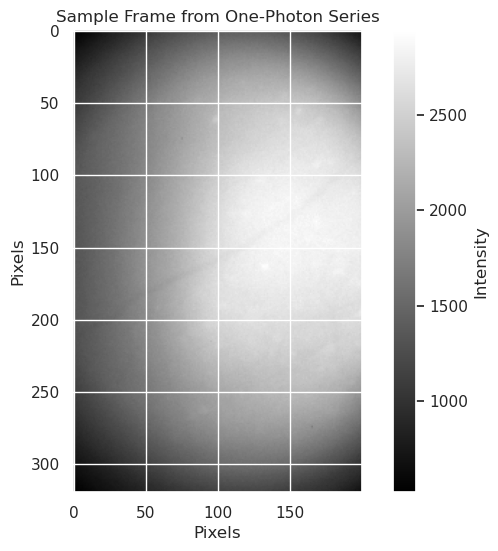

In [4]:
# Plot a sample frame
sample_frame = nwb.acquisition["OnePhotonSeries"].data[1000]
plt.figure(figsize=(8, 6))
plt.imshow(sample_frame, cmap='gray')
plt.colorbar(label='Intensity')
plt.title('Sample Frame from One-Photon Series')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.show()

The image above shows a single frame from the calcium imaging recording. The grayscale intensity represents the fluorescence level at each pixel, with brighter regions indicating higher calcium activity.

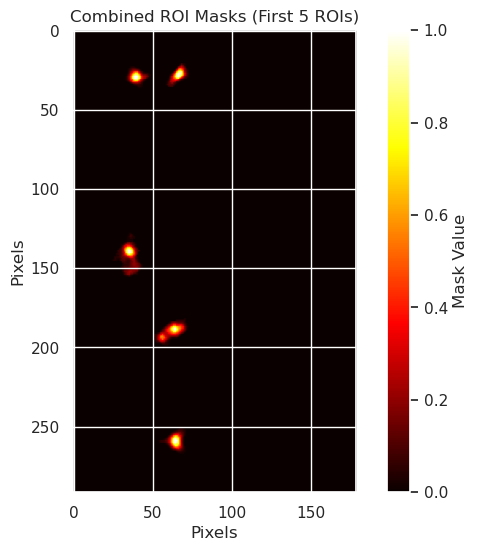

In [5]:
# Visualize ROI masks for the first 5 ROIs
image_masks = nwb.processing["ophys"]["ImageSegmentation"]["PlaneSegmentation"]["image_mask"].data[:5]
combined_mask = np.zeros_like(image_masks[0])
for mask in image_masks:
    combined_mask = np.maximum(combined_mask, mask)

plt.figure(figsize=(8, 6))
plt.imshow(combined_mask, cmap='hot')
plt.colorbar(label='Mask Value')
plt.title('Combined ROI Masks (First 5 ROIs)')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.show()

The image above shows the spatial locations of the first 5 ROIs (neurons) identified in the recording. Each bright spot represents a different neuron. The ROIs are well-separated spatially, allowing for clean extraction of individual cellular activity.

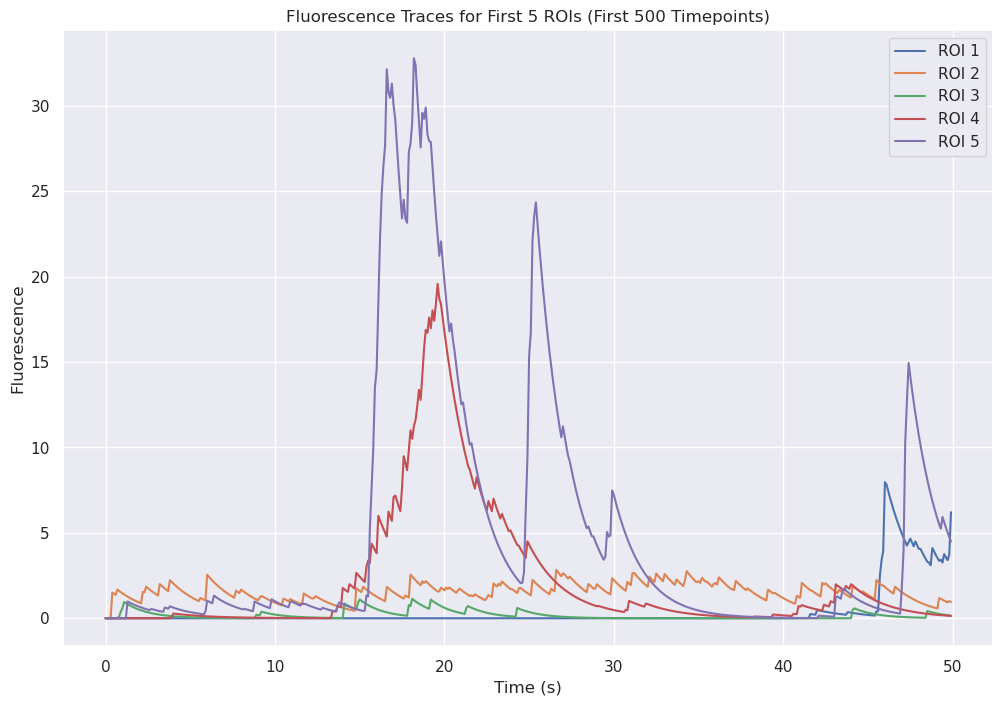

In [6]:
# Plot fluorescence traces for first 5 ROIs
fluorescence_data = nwb.processing["ophys"]["Fluorescence"]["RoiResponseSeries"].data[:500, :5]
time_points = np.arange(500) / nwb.acquisition["OnePhotonSeries"].rate

plt.figure(figsize=(12, 8))
for i in range(5):
    plt.plot(time_points, fluorescence_data[:, i], label=f'ROI {i+1}')
plt.xlabel('Time (s)')
plt.ylabel('Fluorescence')
plt.title('Fluorescence Traces for First 5 ROIs (First 500 Timepoints)')
plt.legend()
plt.show()

The plot above shows the fluorescence traces for the first 5 ROIs over time. Each trace represents the calcium activity of a single neuron. Key observations:
- Clear calcium events (sharp increases in fluorescence) are visible in several ROIs
- Some ROIs show coordinated activity (e.g., ROIs 4 and 5 around 20s)
- Different ROIs show varying levels of baseline activity and event frequencies

## Example Analysis: Basic Event Detection

Let's perform a simple analysis to detect potential calcium events in the fluorescence traces. Here, we'll identify timepoints where the fluorescence exceeds a threshold above the mean.

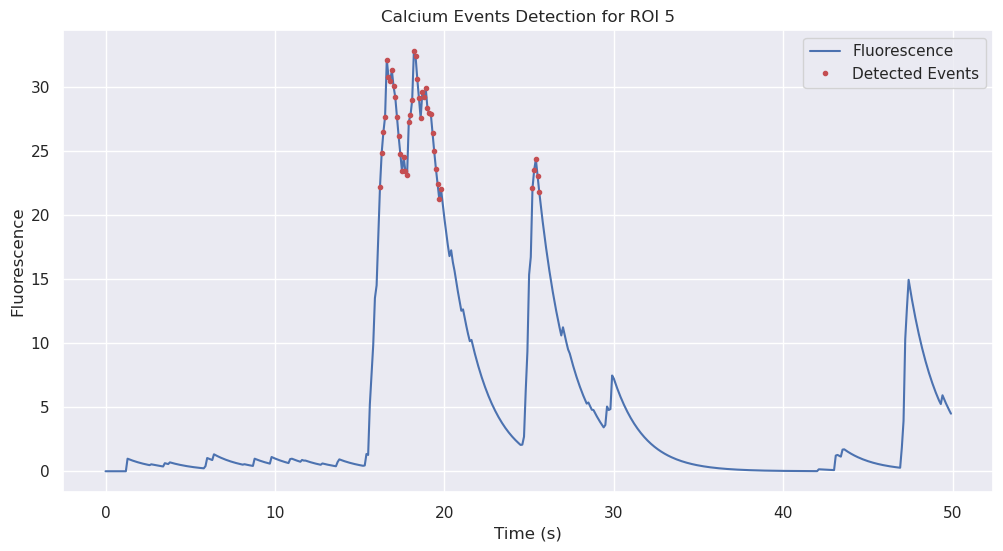


Event Statistics for ROI 5:
Number of events: 42
Event rate: 0.84 events/second


In [7]:
def detect_events(trace, threshold_std=2):
    """
    Simple event detection based on threshold crossing.
    
    Args:
        trace: fluorescence trace
        threshold_std: number of standard deviations above mean for threshold
    
    Returns:
        events: boolean array indicating timepoints with events
    """
    baseline = np.mean(trace)
    threshold = baseline + threshold_std * np.std(trace)
    return trace > threshold

# Analyze events in first ROI
roi_idx = 4  # ROI showing clear events
trace = fluorescence_data[:, roi_idx]
events = detect_events(trace)

plt.figure(figsize=(12, 6))
plt.plot(time_points, trace, label='Fluorescence')
plt.plot(time_points[events], trace[events], 'r.', label='Detected Events')
plt.xlabel('Time (s)')
plt.ylabel('Fluorescence')
plt.title(f'Calcium Events Detection for ROI {roi_idx + 1}')
plt.legend()
plt.show()

# Print some basic statistics
print(f"\nEvent Statistics for ROI {roi_idx + 1}:")
print(f"Number of events: {np.sum(events)}")
print(f"Event rate: {np.sum(events)/time_points[-1]:.2f} events/second")

## Next Steps

This notebook demonstrates basic loading and visualization of calcium imaging data from the DANDI:001174 dataset. Researchers might want to explore:

1. **Advanced Event Detection**:
   - Implement more sophisticated algorithms for detecting calcium events
   - Account for varying baseline fluorescence
   - Consider temporal dynamics in event detection

2. **Population Analysis**:
   - Examine correlations between different ROIs
   - Study population-level activity patterns
   - Relate neural activity to behavioral events

3. **Behavioral Correlations**:
   - Link calcium events to specific phases of the reaching task
   - Compare activity patterns between rest and reaching periods
   - Analyze trial-to-trial variability

4. **Spatial Analysis**:
   - Map the spatial organization of active neurons
   - Study whether nearby neurons show correlated activity
   - Examine whether spatial patterns relate to functional properties